In [1]:
import os
os.chdir("../")

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from src.hold_detection.detectron.HoldSegmentator import HoldSegmentator
from src.hold_matching.HoldMatcher import HoldMatcher
from src.utils.config import load_config
from src.utils.detectron_utils import plot_predictions

In [4]:
global_config, local_config = load_config()

In [5]:
image_file_name = "PXL_20230412_192551425.MP.jpg"
video_file_name = "pose_estimation_2.mp4"
model_config_file_name = "hold-detector_cfg.pickle"

In [6]:
image = cv2.imread(local_config['PATH']['raw_routes'] + "test_set\\" + image_file_name)
image = cv2.resize(image, (0, 0), fx=0.75, fy=0.75)
image_height = image.shape[0]
image_width = image.shape[1]
print(image.shape)

(3024, 1701, 3)


In [7]:
frames = []
cap = cv2.VideoCapture(local_config['PATH']['raw_videos'] + video_file_name)
while(cap.isOpened):
    ret, frame = cap.read()
    if ret:
        frames.append(frame)
    else:
        break
cap.release()
print(frames[0].shape)

(1920, 1080, 3)


In [8]:
def click_event(event, x, y, flags, param):
    global selected_indices
    global image_predictions
    global plotted_image
    if event == cv2.EVENT_LBUTTONDOWN:
        # loop over each instance
        for index in range(len(image_predictions["instances"])):
            # get the bounding box coordinates
            x1, y1, x2, y2 = (
                image_predictions["instances"][index]
                .get("pred_boxes")
                .tensor
                .cpu()
                .tolist()[0]
            )
            if x > x1 and x < x2 and y > y1 and y < y2:
                selected_indices.append(index)
                
        plotted_image = plot_predictions(
            image.copy(),
            image_predictions["instances"][selected_indices],
        )
        cv2.imshow("image", cv2.cvtColor(plotted_image, cv2.COLOR_BGR2RGB))

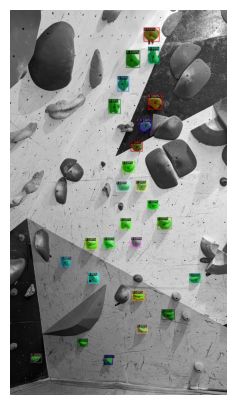

In [28]:
image_detector = HoldSegmentator(
    local_config['PATH']['config']+model_config_file_name,
    "model_final.pth",
    0.9,
    0.2
)
image_predictions = image_detector.predict(image)
selected_indices = []

cv2.namedWindow("image", cv2.WINDOW_NORMAL)
cv2.resizeWindow("image", 540, 960)
cv2.setMouseCallback("image", click_event)

plotted_image = plot_predictions(image.copy(), image_predictions["instances"][selected_indices])

cv2.imshow("image", cv2.cvtColor(plotted_image, cv2.COLOR_BGR2RGB))

while True:
    # Press 'q' to quit after selecting instances
    if cv2.waitKey(0) & 0xFF == ord("q"):
        break
cv2.destroyAllWindows()

plotted_image = plot_predictions(
    image.copy(),
    image_predictions["instances"][selected_indices],
    color_mode="IMAGE_BW"
)
fig = plt.figure(figsize=(10,5))
plt.axis('off')
plt.imshow(plotted_image)
plt.show()

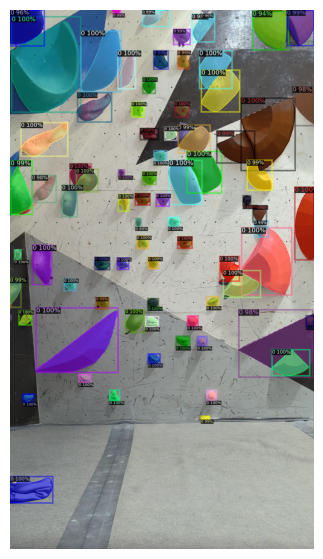

In [29]:
initial_frame = frames[0].copy()

video_detector = HoldSegmentator(
    local_config['PATH']['config']+model_config_file_name,
    "model_final.pth",
    0.8,
    0.5
)
video_predictions = video_detector.predict(frames[0])

plotted_frame = plot_predictions(frames[0].copy(), video_predictions["instances"])
fig = plt.figure(figsize=(15,7))
plt.axis('off')
plt.imshow(plotted_frame)
plt.show()

In [113]:
matcher = HoldMatcher()

video_frame_hold_kp_counts = {
    index: 0 for index in range(
        len(video_predictions["instances"])
    )
}
bb_margin = int(image_height * 0.01)
for hold_index in selected_indices:
    bbox = (
        image_predictions["instances"][hold_index]
        .get("pred_boxes")
        .tensor
        .cpu()
        .numpy()[0]
    )

    hold_area = image[
        int(max(0, bbox[1]-bb_margin)):int(min(image_height, bbox[3]+bb_margin)),
        int(max(0, bbox[0]-bb_margin)):int(min(image_width, bbox[2]+bb_margin))
    ].copy()
        
    kp1, kp2, good_matches = matcher.match(hold_area, initial_frame, 0.75)
    matched_points = [
        kp2[match[0].trainIdx].pt
        for match in good_matches
    ]
        
    if len(matched_points) > 0:
        hold_hsv_mean = cv2.mean(
                cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[:,:,0], 
                mask=(
                    image_predictions["instances"][hold_index]
                    .get("pred_masks")
                    .cpu()
                    .numpy()[0] * 255
                    ).astype(np.uint8)
        )[0]
        
        for index in range(len(video_predictions["instances"])):
            bbox = (
                video_predictions["instances"][index]
                .get("pred_boxes")
                .tensor
                .cpu()
                .numpy()[0]
            )       
            for point in matched_points:
                if (
                    bbox[0] < point[0] < bbox[2] and
                    bbox[1] < point[1] < bbox[3]
                ):
                    video_frame_hold_kp_counts[index] += 1
                    
            candidate_hsv_mean = cv2.mean(
                cv2.cvtColor(initial_frame, cv2.COLOR_BGR2HSV)[:,:,0], 
                mask=(
                    video_predictions["instances"][index]
                    .get("pred_masks")
                    .cpu()
                    .numpy()[0] * 255
                    ).astype(np.uint8)
            )[0]
            
            if candidate_hsv_mean < hold_hsv_mean+30 and candidate_hsv_mean > hold_hsv_mean-30:
                video_frame_hold_kp_counts[index] += 10
                        

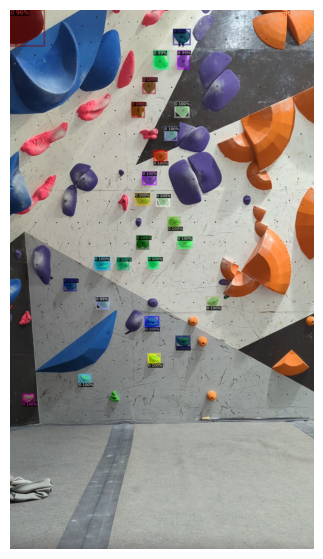

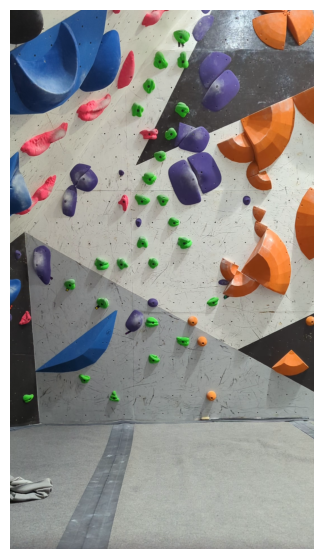

In [116]:
sorted_dict = sorted(
    video_frame_hold_kp_counts.items(), 
    key=lambda x: x[1], 
    reverse=True
)
hold_candidates = [key for key, v in sorted_dict[:len(selected_indices)]]


plotted_frame = plot_predictions(initial_frame.copy(), video_predictions["instances"][hold_candidates])
fig = plt.figure(figsize=(15,7))
plt.axis('off')
plt.imshow(plotted_frame)
plt.show()
fig = plt.figure(figsize=(15,7))
plt.axis('off')
plt.imshow(cv2.cvtColor(initial_frame, cv2.COLOR_BGR2RGB))
plt.show()

In [118]:
sorted_dict[:30]

[(17, 275),
 (19, 271),
 (13, 268),
 (30, 268),
 (59, 268),
 (14, 267),
 (22, 267),
 (32, 267),
 (37, 267),
 (61, 267),
 (25, 266),
 (51, 266),
 (62, 266),
 (9, 265),
 (23, 265),
 (57, 265),
 (16, 264),
 (21, 264),
 (49, 264),
 (4, 263),
 (35, 263),
 (7, 262),
 (34, 262),
 (38, 262),
 (75, 261),
 (1, 260),
 (2, 260),
 (20, 260),
 (26, 4),
 (33, 4)]

(57.829074389551394, 0.0, 0.0, 0.0)


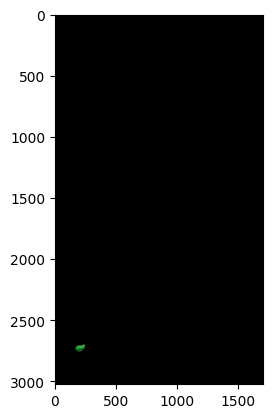

In [106]:
mask = (image_predictions["instances"][selected_indices[-1]].get("pred_masks").cpu().numpy()[0] * 255).astype(np.uint8)
print(cv2.mean(cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[:,:,0], mask=mask))
black_image1 = np.zeros(image.shape, np.uint8)
black_image1[mask != 0] = image[mask != 0]
plt.imshow(black_image1)

(127.79731993299832, 0.0, 0.0, 0.0)


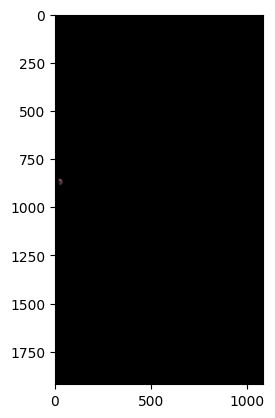

In [112]:
mask = (video_predictions["instances"][0].get("pred_masks").cpu().numpy()[0] * 255).astype(np.uint8)
print(cv2.mean(cv2.cvtColor(initial_frame, cv2.COLOR_BGR2HSV)[:,:,0], mask=mask))
black_image2 = np.zeros(initial_frame.shape, np.uint8)
black_image2[mask != 0] = initial_frame[mask != 0]
plt.imshow(black_image2)

In [93]:
kp1, kp2, good_matches = matcher.match(black_image1, black_image2, 0.75)

In [94]:
good_matches

[[< cv2.DMatch 000001EDA917A3F0>],
 [< cv2.DMatch 000001EDEEBA3330>],
 [< cv2.DMatch 000001EDA930E030>],
 [< cv2.DMatch 000001EDA930E070>],
 [< cv2.DMatch 000001EDA930E2F0>]]